In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical
from sklearn import metrics
import h5py
from sklearn import utils
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
right_images = np.load('20200514_right__Chiral_D_Large_TIFF_Cropped_four_rows_sel_NPs_rotated.npy')
right_labels = [[1,0] for i in np.arange(0,len(right_images))]

In [6]:


new_left_images = []
new_left_labels = []
new_right_images = []
new_right_labels = []


for img in right_images:
    new_left_images.append(np.fliplr(img))
    new_left_labels.append([0,1])
    new_right_images.append(img)
    new_right_labels.append([1,0])
new_left_images = np.array(new_left_images)
new_right_images = np.array(new_right_images)

split = int(191*0.2)

flipped_right_indices = np.random.choice(np.arange(0,191),split,replace=False)
flipped_left_indices = np.random.choice(np.arange(0,191),split,replace=False)

for idx in flipped_right_indices:
    new_right_images[idx] = np.fliplr(new_right_images[idx])

for idx in flipped_left_indices:
    new_left_images[idx] = np.fliplr(new_left_images[idx])

right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[:191], new_right_labels[:191],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[:191], new_left_labels[:191],random_state=0)

X_train = np.concatenate((right_img_shuff[:191],left_img_shuff[:191]),axis =0)
Y_train = np.concatenate((right_label_shuff[:191],left_label_shuff[:191]),axis = 0)

split = int(95*0.2)

flipped_right_indices = np.random.choice(np.arange(191,286),split,replace=False)
flipped_left_indices = np.random.choice(np.arange(191,286),split,replace=False)

for idx in flipped_right_indices:
    new_right_images[idx] = np.fliplr(new_right_images[idx])

for idx in flipped_left_indices:
    new_left_images[idx] = np.fliplr(new_left_images[idx])

right_img_shuff, right_label_shuff = utils.shuffle(new_right_images[191:286], new_right_labels[191:286],random_state=0)
left_img_shuff, left_label_shuff = utils.shuffle(new_left_images[191:286], new_left_labels[191:286],random_state=0)


X_test = np.concatenate((right_img_shuff,left_img_shuff),axis = 0)
Y_test = np.concatenate((right_label_shuff,left_label_shuff),axis = 0)

X_train_norm = X_train/X_train.max()
X_test_norm = X_test/X_test.max()
X_train_norm = np.expand_dims(X_train_norm,axis=3)
X_test_norm = np.expand_dims(X_test_norm,axis=3)

X_train_shuff, Y_train_shuff = utils.shuffle(X_train_norm, Y_train,random_state=0)
X_test_shuff, Y_test_shuff = utils.shuffle(X_test_norm, Y_test,random_state=0)

batch_size = 25
seed = 42
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=False,
        vertical_flip = False)

test_datagen = ImageDataGenerator(rescale=1.)

train_generator = train_datagen.flow(X_train_shuff, y=Y_train_shuff, batch_size=batch_size,seed=seed)
val_generator = test_datagen.flow(X_test_shuff,y=Y_test_shuff,batch_size=batch_size,seed=seed)

In [7]:
modelE = keras.models.Sequential()
modelE.add(Conv2D(32, (3, 3), input_shape=(128, 128,1)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(32, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelE.add(Dense(64))
modelE.add(Activation('relu'))
modelE.add(Dropout(0.5))
modelE.add(Dense(2))
modelE.add(Activation('softmax'))

modelE.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [8]:
save_weights = 'chirality_classification_20pwrongleftrightlabels_weights_20200820.h5'

In [9]:
clear_session()

In [10]:
historyE = modelE.fit(
        train_generator,
        steps_per_epoch=2500,
        epochs=15,
        validation_data=val_generator,
        validation_steps=200)

Epoch 1/15
2500/2500 [==============================] - 444s 178ms/step - loss: 0.6467 - accuracy: 0.5845 - val_loss: 0.6791 - val_accuracy: 0.6421
Epoch 2/15
2500/2500 [==============================] - 425s 170ms/step - loss: 0.4292 - accuracy: 0.7824 - val_loss: 0.8672 - val_accuracy: 0.6571
Epoch 3/15
2500/2500 [==============================] - 419s 168ms/step - loss: 0.3649 - accuracy: 0.8044 - val_loss: 1.2581 - val_accuracy: 0.6476
Epoch 4/15
2500/2500 [==============================] - 438s 175ms/step - loss: 0.3713 - accuracy: 0.8057 - val_loss: 1.4758 - val_accuracy: 0.6411
Epoch 5/15
2500/2500 [==============================] - 432s 173ms/step - loss: 0.3826 - accuracy: 0.8031 - val_loss: 1.7439 - val_accuracy: 0.6684
Epoch 6/15
2500/2500 [==============================] - 442s 177ms/step - loss: 0.3937 - accuracy: 0.7996 - val_loss: 0.7841 - val_accuracy: 0.6276
Epoch 7/15
2500/2500 [==============================] - 453s 181ms/step - loss: 0.4112 - accuracy: 0.7958 - val_

In [28]:
modelE.save_weights(save_weights)

In [29]:
np.save('Te_X_train_shuff_20200820.npy',X_train_shuff)
np.save('Te_Y_train_shuff_20200820.npy',Y_train_shuff)
np.save('Te_X_test_shuff_20200820.npy',X_test_shuff)
np.save('Te_Y_test_shuff_20200820.npy',Y_test_shuff)

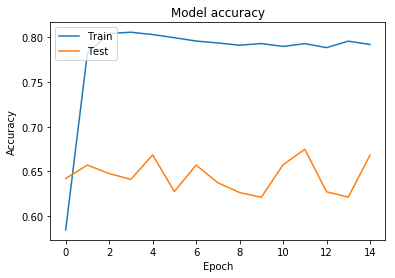

In [11]:
plt.plot(historyE.history['accuracy'])
plt.plot(historyE.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

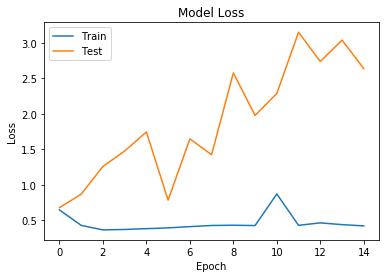

In [12]:
plt.plot(historyE.history['loss'])
plt.plot(historyE.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
X_val = np.concatenate((new_right_images[286:],new_left_images[286:]),axis = 0)
Y_val = np.concatenate((new_right_labels[286:],new_left_labels[286:]),axis = 0)
X_val = X_val/X_val.max()
X_val_norm = np.expand_dims(X_val,axis=3)

X_val_shuff, Y_val_shuff = utils.shuffle(X_val_norm, Y_val,random_state=0)

In [30]:
np.save('Te_X_val_shuff_20200820.npy',X_val_shuff)
np.save('Te_Y_val_shuff_20200820.npy',Y_val_shuff)

In [14]:
modelE.evaluate(X_val_shuff,Y_val_shuff)

7/7 [==============================] - 0s 38ms/step - loss: 0.4165 - accuracy: 0.8608


[0.4165244698524475, 0.8608247637748718]

In [31]:
pred = modelE.predict(X_val_shuff)

In [16]:
pred

array([[1.1988768e-01, 8.8011235e-01],
       [5.8271599e-18, 1.0000000e+00],
       [8.9266586e-01, 1.0733408e-01],
       [4.2274448e-01, 5.7725555e-01],
       [8.2609004e-01, 1.7390998e-01],
       [9.9998951e-01, 1.0490433e-05],
       [1.4770988e-01, 8.5229015e-01],
       [5.1540095e-01, 4.8459902e-01],
       [5.1279747e-01, 4.8720250e-01],
       [1.0000000e+00, 1.1698843e-10]], dtype=float32)

In [18]:
Y_val_shuff[:10]

array([[0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0]])

In [21]:
pred.shape

(10, 2)

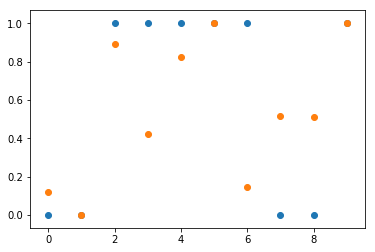

In [27]:
plt.scatter(np.arange(0,10),Y_val_shuff[:10,0])
plt.scatter(np.arange(0,10),pred[:,0])
# plt.plot(np.arange(0,10),Y_val_shuff[:10,1],alpha=0.4)